# Solar Radiation Prediction

Data analysis on a 4 months dataset collected at the HI-SEAS weather station (Hawaii). The observation sampling rate is 5 minutes and collected features/variables are:

- Solar radiation [W/m^2]
- Temperature [F]
- Atmospheric pressure [Hg]
- Humidity [%]
- Wind speed [miles/h]
- Wind direction [degrees]
- Time sun rise
- TIme sun set

The dataset is a time series with cyclicality(day) and seasonality(months). It is obvious that solar radiation is a function of duration of day light(among other features), thus we
will do time feature engineering in order to account for the relative time of day.

Goal is to train ML model to predict solar radiation as a function of the above features. Particulariy, we will establish a base line with a simple regression model and then we will use
assambles (Random Forest, Gradient Boosting) with Random Grid Search hyper-parameter tuning. R^2 and Mean-Squared-Error(MSE) used as model evaluation metrics. 

We wil evaluate two feature creation strategies. Two scenarios:
- Relative time: Time of the day is treated relatively to daylight duration. Daylight duration is taken into account.
- Sun is ip feature: Indicates whether the observation was made during [sunrise, sunset]

## Load dataset and Preperation

In [54]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.tz import *
import matplotlib.pyplot as plt
import seaborn as sns
#pd.to_datetime deprecation warning
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

startDateVisual = '14-10-2016' 
endDateVisual = '24-10-2016'
test_size = 0.3
series_split = 3
tree_based_estimators = [100, 300, 500, 800] #[100,300,500,800]

# scores list from different models
SCORES_ = []

### FeatureCreation: Helper class to automate data preprocessing and feature creation

In [55]:

class FeatureCreation:
    def __init__(self, featureCase):
        self.featureCase = featureCase
        self.df = None

    
    def loadDataset(self, fileName):
        try:
            self.df = pd.read_csv(fileName)
        except FileNotFoundError as notFound:
            raise notFound
            
    def sanityCheck(self):
        self.df.info()
        print('\nCheck to nan/null')
        self.df.isnull().sum()
        
    def fixTimeZone(self):
        '''Convert column UNIXTime to datetime object and set correct Time zone. Data collected at HST, 
            Hawaii Standard Zone
        '''
        self.df['Date'] = self.df['UNIXTime'].astype('datetime64[s]')
        #Set time zone
        self.df['Date'] = self.df['Date'].dt.tz_localize('UTC').dt.tz_convert('HST')
        
    
    def timeConversion(self):
        ''' Convert features TimeSunRise and TimeSunSet to include actual date of the observation '''
        
        try:
            # #Holds actual observation time
            self.df['Data'] = pd.to_datetime(self.df['Data']).dt.date

            #Convert TimeSunRise and TimeSunSet features datetime.time objects
            self.df['TimeSunRise'] = pd.to_datetime(self.df['TimeSunRise']).dt.time
            self.df['TimeSunSet'] = pd.to_datetime(self.df['TimeSunSet']).dt.time

            #Create new sunset/sunrise features with observation time
            self.df['sunrise_time'] = self.df.apply(lambda row: pd.datetime.combine(row['Data'], row['TimeSunRise']), axis = 1)
            self.df['sunset_time'] = self.df.apply(lambda row: pd.datetime.combine(row['Data'], row['TimeSunSet']), axis = 1)

            #Correct timezone(HST)
            self.df['sunrise_time'] = self.df['sunrise_time'].dt.tz_localize('HST')
            self.df['sunset_time'] = self.df['sunset_time'].dt.tz_localize('HST')

            #Set index
            self.df.set_index('Date', inplace = True)

            #Sort by index
            self.df.sort_index()
        except KeyError as ke:
            print(ke)

    
    def dropColumns(self, columns):
        try:
            self.df.drop(columns = columns, inplace = True)
        except KeyError as ke:
            print(ke)
            
            
    def createFeature(self):
        '''based on self.featureCases it transforms the data accordingly. Supported transformations are
            a) RelativeTime -> relative time of observation in respect to daylight
            b) Sun is up only
        '''
        
        if self.featureCase == 'rel_time':
            self.relativeTimeFeature()
        elif self.featureCase == 'sun_is_up':
            self.sunIsUp()
        
        
    def relativeTimeFeature(self):
        print('Creating feature:', self.featureCase)
        #Converting sunrise and sunset times into timestamp
        self.df['sunrise_timestamp'] = self.df.apply(lambda row: datetime.timestamp(row['sunrise_time']), axis = 1)
        self.df['sunset_timestamp'] = self.df.apply(lambda row: datetime.timestamp(row['sunset_time']), axis = 1)

        #Creating a column containing the number of daily light hours
        self.df['Daylight_duration'] = (self.df['sunset_timestamp'] - self.df['sunrise_timestamp'])/60/60

        #Creating column describing current time relative to sunrise/sunset
        self.df['Rel_time'] = (self.df['UNIXTime']- self.df['sunrise_timestamp'])/(self.df['sunset_timestamp']-self.df['sunrise_timestamp'])

        #Removing unnecessary features/columns
        self.dropColumns(['UNIXTime','sunrise_timestamp', 'sunset_timestamp', 'sunset_time', 'sunrise_time'])
        
        
        
    def daylight(self, current_time, rising_time, set_time):
        return (rising_time < current_time) and (current_time < set_time)

    def sunIsUp(self):
        print('Creating feature', self.featureCase)
        sun_is_up = [self.daylight(self.df.index[index], self.df["sunrise_time"][index], self.df["sunset_time"][index]) for index in range(self.df.shape[0])]
        sun_is_up = np.array(sun_is_up, dtype = int)
        self.df["sun_is_up"] = sun_is_up
        
        proportion = round(sum(self.df["sun_is_up"]/self.df.shape[0]*100), 2)
        print("Proportion of record with the sun up : {0}%".format(proportion))
            
    

### Data preprocessing and Relative time Scenario

In [56]:
''' Import dataset and inspect observations(nan values) '''
RelTimeCase = FeatureCreation('rel_time')
RelTimeCase.loadDataset("solar_radiation_dataset.csv")
# check for nulls
RelTimeCase.sanityCheck()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB

Check to nan/null


Dataset has wrong default timezone set. Since we know the location where data had been collected we set the correct timezone which is Hawaii Standard Zone(HSZ)

In [57]:
#Fix time zone
RelTimeCase.fixTimeZone()
RelTimeCase.df.head()


,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Date
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,2016-09-29 23:55:26-10:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,2016-09-29 23:50:23-10:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,2016-09-29 23:45:26-10:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,2016-09-29 23:40:21-10:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,2016-09-29 23:35:24-10:00


Feature 'Data' does not contain a valid Time of the day but only the correct Date of the observation. We will create two new columns, sunrise_time and sunset_time which will include the actual sun-set and sun-rise for specific day. Thus will combine parts of 'Data' with TimeSunRise and TimeSunSet respectevely.

Then we drop unnecessary columns (Data', 'Time', 'TimeSunRise', 'TimeSunSet)

In [58]:
RelTimeCase.timeConversion()
RelTimeCase.dropColumns(['Data', 'Time', 'TimeSunRise', 'TimeSunSet'])
RelTimeCase.df.head()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,sunrise_time,sunset_time
Date,,,,,,,,,
2016-09-29 23:55:26-10:00,1475229326,1.21,48,30.46,59,177.39,5.62,2016-09-29 06:13:00-10:00,2016-09-29 18:13:00-10:00
2016-09-29 23:50:23-10:00,1475229023,1.21,48,30.46,58,176.78,3.37,2016-09-29 06:13:00-10:00,2016-09-29 18:13:00-10:00
2016-09-29 23:45:26-10:00,1475228726,1.23,48,30.46,57,158.75,3.37,2016-09-29 06:13:00-10:00,2016-09-29 18:13:00-10:00
2016-09-29 23:40:21-10:00,1475228421,1.21,48,30.46,60,137.71,3.37,2016-09-29 06:13:00-10:00,2016-09-29 18:13:00-10:00
2016-09-29 23:35:24-10:00,1475228124,1.17,48,30.46,62,104.95,5.62,2016-09-29 06:13:00-10:00,2016-09-29 18:13:00-10:00


In this approach we assume(though reasonable assumption) that solar radiation approaches to zero outsite of sun light period. Before Sunrise and After sunset. 
In order to validate this assumption, we will choose 5 random days from the dataset and plot the radiation as a function of time. 
We also add 2 vertical lines which denote the day light period.

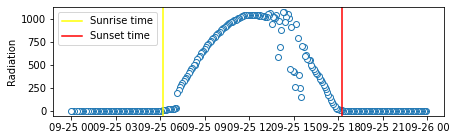

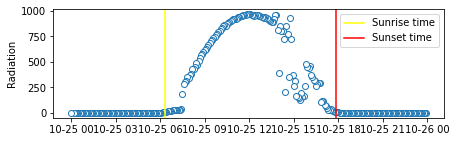

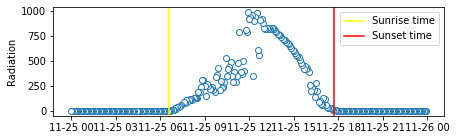

In [59]:
'''It is reasonable to expect that the solar radiation, for any  day, would be approximately zero before the sunrise and after the sunset time. 
Quick visualization check '''
df_random_days = [RelTimeCase.df.loc['2016-09-25':'2016-09-25',:], 
                    RelTimeCase.df.loc['2016-10-25':'2016-10-25',:],
                    RelTimeCase.df.loc['2016-11-25':'2016-11-25',:]]

for day in df_random_days:
    plt.figure(figsize = (7,2))
    plt.plot(day.Radiation, 'o', markerfacecolor = 'w')

    #Plotting vertical line at sunrise
    plt.axvline(day.sunrise_time.iloc[0], label = 'Sunrise time', color = 'yellow')

    #Plotting vertical line at sunset
    plt.axvline(day.sunset_time.iloc[0], label = 'Sunset time', color = 'red') 
    #Adjusting timezone of x-axis
    plt.gca().xaxis_date('HST')
    plt.ylabel('Radiation')
    plt.legend()
    plt.show()



Above plots confirm the assumption as well the the correct manipulation of time/dates.

## Preliminary Analysis

We check the range of each feature to see if they make sense, clean dataset.

In [60]:
''' Check ranges for each feature, see if the make sense '''
RelTimeCase.df.describe()


,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000


All values seem to make sense.

### Distribution of features

Understand how the each feature is allocated between their lower and upper limits.

In [61]:
def featureDistPlots(df):
    ''' Check distribution of features '''
    fig, ax = plt.subplots(nrows =2, ncols = 6, figsize = (25, 10))
    features = ['Radiation', 'Temperature','Pressure', 'Humidity', 'Speed', 'WindDirection(Degrees)']
    index = 0

    #Distribution
    for feature in features:
        sns.distplot(x=df[feature], ax = ax[0,index])
        ax[0,index].set_xlabel(feature, fontsize = 14)
        index += 1

    #Box plots
    index = 0
    for feature in features:
        sns.boxplot(x=df[feature], ax = ax[1,index])
        ax[0,index].set_xlabel(feature, fontsize = 14)
        index += 1


    fig.suptitle('Distribution and box plots', fontsize = 22)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)

    plt.show()

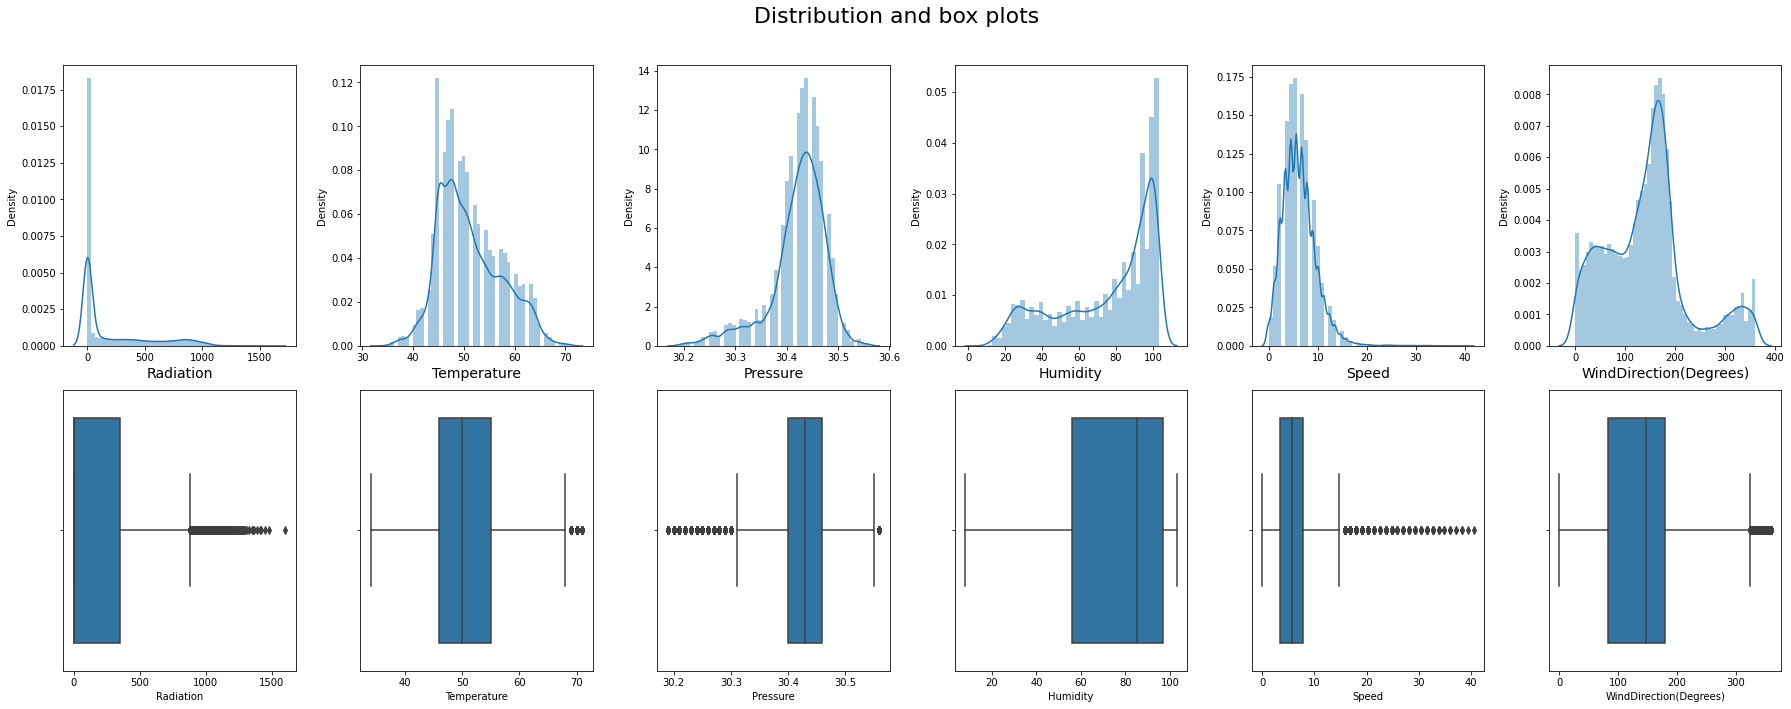

In [62]:
# Distribution and Box plots
featureDistPlots(RelTimeCase.df)

Looking at the distribution of the data it is possible to conclude that most features have a skewed distribution, except for the wind direction, which has three peaks.

## Feature Engineering

We consider that all features included in the dataset, are usefull for prediction of target value (Radiation).
We also need to take into account the time of the day as an indication because radiation heavily depends on solar position
on the sky and the duration of day light of each day.

We define 2 new features.
- Relative time of day (Rel_time) = $\frac{\text{Current time - Sunrise Time}}{\text{Sunrise Time - Sunset Time}}$
    - Rel_time < 0, if before sunrise
    - Rel_time = 0 at exact sunrise time
    - Rel_time (0,1) between sunrise and sunset
    - Rel_time = 1 at exact sunset time
    - Rel_time > 1 if after sunset
    
- Solar day duration (Daylight_duration) = $\text{Sunrise Time - Sunset Time}$

In [63]:
'''In this first appoach we would like to create a new feature which will indicate the relative time
of the day the observation was performed in relation to daylight duration.
We call the createFeature method from FeatureCreation class'''
RelTimeCase.createFeature()

Creating feature: rel_time


In [64]:
RelTimeCase.df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Daylight_duration,Rel_time
Date,,,,,,,,
2016-09-29 23:55:26-10:00,1.21,48,30.46,59,177.39,5.62,12.0,1.475602
2016-09-29 23:50:23-10:00,1.21,48,30.46,58,176.78,3.37,12.0,1.468588
2016-09-29 23:45:26-10:00,1.23,48,30.46,57,158.75,3.37,12.0,1.461713
2016-09-29 23:40:21-10:00,1.21,48,30.46,60,137.71,3.37,12.0,1.454653
2016-09-29 23:35:24-10:00,1.17,48,30.46,62,104.95,5.62,12.0,1.447778


## Features Correlation

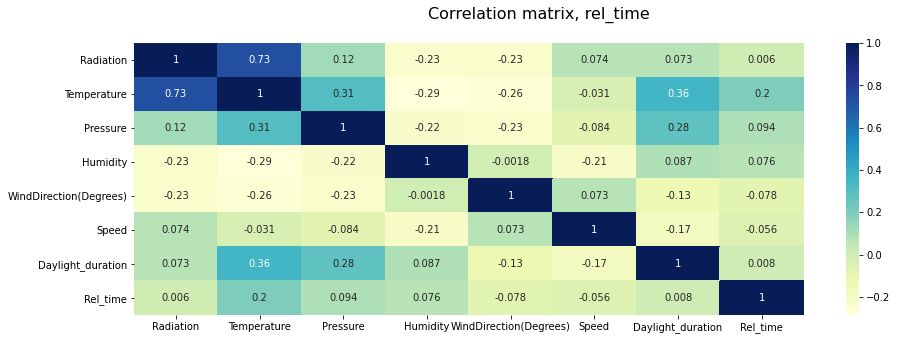

In [65]:
def corrMatrix(data, case):
    #Plotting a heatmap of the various features in the dataset
    fig, ax = plt.subplots(figsize = (15,5))
    sns.heatmap(data.corr(), annot = True, cmap = 'YlGnBu')
    fig.suptitle('Correlation matrix, '+ case, fontsize = 16)
    plt.show()

corrMatrix(RelTimeCase.df, 'rel_time')

The correlation matrix indicates a positive linear correlation between the ambient temperature and the solar radiation (coefficient = 0.73). No clear linear correlation appears for the other features, and the second highest correlation value is identified for the humidity (yet it is only of -0.23).

As a second step in the correlation analysis, it is possible to draw scatter plots showing the distribution of the values of the various features as a function of the value of the target parameter (solar radiation). This allows to identify potential non-linear trends present.

## Features scatter function of Radiation

In [66]:
def scatterPlots(df):
    fig, ax = plt.subplots(nrows =2, ncols = 4, figsize = (23,8))

    ax[0,0].plot(df.Temperature, df.Radiation,'o', markerfacecolor='w')
    ax[0,0].set_xlabel('Temperature [F]', fontsize = 14)
    ax[0,0].set_ylabel('Radiation [W/m^2]', fontsize = 14)

    ax[0,1].plot(df.Pressure, df.Radiation,'o', markerfacecolor='w')
    ax[0,1].set_xlabel('Pressure [Hg]', fontsize = 14)
    ax[0,1].set_ylabel('Radiation [W/m^2]', fontsize = 14)

    ax[0,2].plot(df.Humidity, df.Radiation,'o', markerfacecolor='w')
    ax[0,2].set_xlabel('Humidity [%]', fontsize = 14)
    ax[0,2].set_ylabel('Radiation [W/m^2]', fontsize = 14)

    ax[0,3].plot(df.Daylight_duration, df.Radiation,'o', markerfacecolor='w')
    ax[0,3].set_xlabel('Hours of light [h]', fontsize = 14)
    ax[0,3].set_ylabel('Radiation [W/m^2]', fontsize = 14)

    ax[1,0].plot(df.Rel_time, df.Radiation,'o', markerfacecolor='w')
    ax[1,0].set_xlabel('Rel_time', fontsize = 14)
    ax[1,0].set_ylabel('Radiation [W/m^2]', fontsize = 14)

    ax[1,1].plot(df.Speed, df.Radiation,'o', markerfacecolor='w')
    ax[1,1].set_xlabel('Wind speed [miles/h]', fontsize = 14)
    ax[1,1].set_ylabel('Radiation [W/m^2]', fontsize = 14)

    ax[1,2].plot(df['WindDirection(Degrees)'], df.Radiation,'o', markerfacecolor='w')
    ax[1,2].set_xlabel('Wind direction [degrees]', fontsize = 14)
    ax[1,2].set_ylabel('Radiation [W/m^2]', fontsize = 14)

    fig.delaxes(ax[1,3])

    fig.suptitle('Scatter plots of the solar radiation as a function of the various features', fontsize = 22)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)

    plt.show()

Positive linear correlation with temperature 
Seems there is a correlation between radiation peak values with pressure peak values.

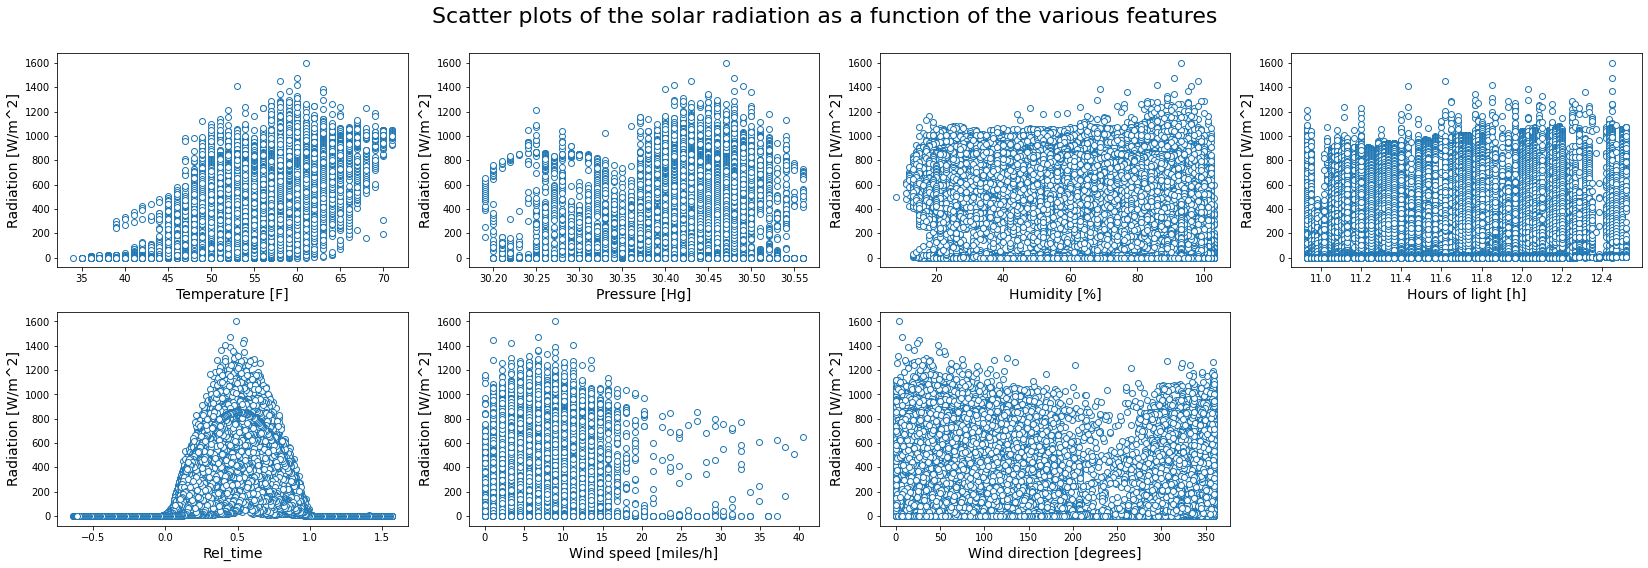

In [67]:
scatterPlots(RelTimeCase.df)

## Models

We are going to set a baseline with a simple linear model and then will use RandomForest and GradientBoosting with RandomGridSearch as hyper-parameter tuning is required for more complicated models.

Evaluation metrics:
- R^2
- Mean Squared Error (MSE)

## Linear Regression

Since will use simple linear regression couple of times we create the LinearRegressionWrapper class. 
Split data to train(70%) and test(30%)

In [68]:
class LinearRegressionWrapper:
    def __init__(self, df, test_size, feature_case):
        self.lm = LinearRegression()
        self.df = df
        self.test_size = test_size
        X = self.df.drop(columns = 'Radiation')
        y = self.df.Radiation
        self.feature_case = feature_case
        #Splitting data into train and test sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X,y,
                                                           test_size = self.test_size,
                                                           random_state = 100)
        self.pred_train = None
        self.pred_test = None
        
    def fit(self):
        self.lm.fit(self.X_train, self.y_train)
    
    def predict(self, x=None):
        if x is None:
            self.pred_train = self.lm.predict(self.X_train)
            self.pred_test = self.lm.predict(self.X_test)
        else:
            return self.lm.predict(x)
    
    def get_scores(self):
        scores_dict = {'model':type(self.lm).__name__,
               'feature_case': self.feature_case,
                'train_mse': '{:.2f}'.format(MSE(self.y_train, self.pred_train)),
                  'test_mse': '{:.2f}'.format(MSE(self.y_test, self.pred_test)),
                   'train_r2': '{:.2f}'.format(r2_score(self.y_train, self.pred_train)),
                   'test_r2' : '{:.2f}'.format(r2_score(self.y_test, self.pred_test))}
        return scores_dict
        

In [69]:
lmRelTime = LinearRegressionWrapper(df = RelTimeCase.df, test_size = test_size, feature_case = 'rel_time')
#Fit model
lmRelTime.fit()
#Predictions
lmRelTime.predict()
#Print scores
lmRelTimeScores = lmRelTime.get_scores()
print(lmRelTimeScores)
SCORES_.append(lmRelTimeScores)

{'model': 'LinearRegression', 'feature_case': 'rel_time', 'train_mse': '38061.81', 'test_mse': '37879.92', 'train_r2': '0.62', 'test_r2': '0.62'}


R^2 in both training and test is similar, indicating that there are no overfitting issues

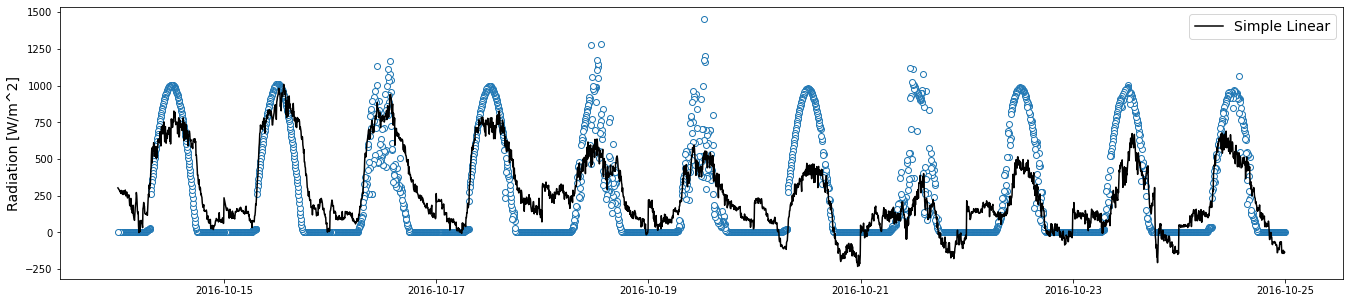

In [70]:
def truncate(data, model, start_date, end_date):
    df_ = data.loc[start_date:end_date,:]
    X_ = df_.drop(columns = 'Radiation')
    y_pred_ = model.predict(x = X_)
    return df_, y_pred_

def visualInspect(x_visual, y_pred_visual, label):
    fig, ax = plt.subplots(figsize = (23,5))    

    ax.plot(x_visual.Radiation,'o', markerfacecolor='w')
    ax.plot(x_visual.index, y_pred_visual, linewidth = 1.5, color = 'black', label = label)
    ax.set_ylabel('Radiation [W/m^2]', fontsize = 14)
    ax.legend(fontsize = 14)

    plt.show()
    
df_visual, y_pred_visual = truncate(RelTimeCase.df, lmRelTime, startDateVisual, endDateVisual)
visualInspect(df_visual, y_pred_visual, 'Simple Linear')

It seems that linear model is doing ok predicting radiation during day light as this was suggested by the relatively high R^2. Though, it is performing poorly during night hours.

### Residuals

Let's have a look on how the residuals of simple model look like. 

$Residual = Observed - Predicted$


In [71]:
def plot_residuals(observed , pred, label):
    res = observed - pred
    fig, ax = plt.subplots(figsize = (23,5))    
    ax.plot(res, label = label)
    ax.legend(fontsize = 14)
    ax.set_ylabel('Residual', fontsize = 14)
    plt.show()

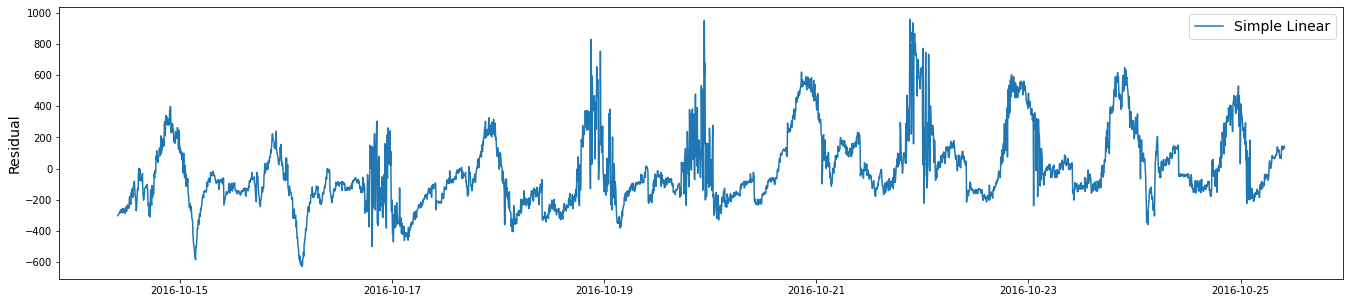

In [72]:
plot_residuals(df_visual.Radiation, y_pred_visual, 'Simple Linear')

From the residuals plot above it is clear that there some systematic patterns in the difference between the observed and predicted values. Ideally, residual plots should look fairly as a random cloud. This is another evidence that a simple linear model cannot describe the variance in our data particularly good.

## Tree-based models

We will use two tree-based models *Random Forest* and *Gradient Boosting* which are capable of capturing non-linear relationships and they do not required featuring scaling.

These models are ensamble models thus hyper-parameters tuning is required for better predictions.  Multiple models are trained as a way to identify the best performing set of hyper-parameters. We will use RandomizedSearch cross validation.

We will create the TreeBasedWrapper class.

In [73]:
class TreeBasedWrapper:
    def __init__(self, model, params, df, test_size, series_split, feature_case):
        self.model = model
        self.params = params
        self.df = df
        self.X = self.df.drop(columns = 'Radiation')
        self.y = self.df.Radiation
        self.series_split = series_split
        #Splitting data into train and test sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y,
                                                           test_size = test_size,
                                                           random_state = 100)
        self.mse_cv = None
        self.tscv = TimeSeriesSplit(series_split)
        self.grid_search = RandomizedSearchCV(estimator = self.model,
                           param_distributions = self.params,
                           cv = self.tscv,
                           scoring = 'neg_mean_squared_error',
                           verbose = 1,
                           n_jobs = 4)
        
        self.best_model_params = None
        self.best_model_ = None
        
        self.y_pred_train = None
        self.y_pred_test = None
        self.feature_case = feature_case
     
    def fit(self):
        self.grid_search.fit(self.X_train, self.y_train)
    
    def best_parameters(self):
        #Extracting best hyperparameters
        self.best_model_params = self.grid_search.best_params_
        print('Best hyperparameters: \n', self.best_model_params)
    
    def best_model(self):
        #Extracting best rf model
        self.best_model_ = self.grid_search.best_estimator_
    
    def cross_validation(self):
        self.mse_cv = -cross_val_score(self.best_model_, self.X_train, self.y_train,
                            cv = self.tscv, 
                            scoring = 'neg_mean_squared_error',
                            n_jobs = 4)
    
    def predict(self, x=None):
        if x is None:
            self.y_pred_train = self.best_model_.predict(self.X_train)
            self.y_pred_test = self.best_model_.predict(self.X_test)
        else:
            return self.best_model_.predict(x)
    
    def get_scores(self):        
        scores_dict = {'model':type(self.model).__name__,
                       'feature_case': self.feature_case,
                       'cv_mse': '{:.2f}'.format(self.mse_cv.mean()),
                        'train_mse': '{:.2f}'.format(MSE(self.y_train, self.y_pred_train)),
                          'test_mse': '{:.2f}'.format(MSE(self.y_test, self.y_pred_test)),
                           'train_r2': '{:.2f}'.format(r2_score(self.y_train, self.y_pred_train)),
                           'test_r2' : '{:.2f}'.format(r2_score(self.y_test, self.y_pred_test))}
        return scores_dict
        

### Random Forest

Random forest, an ensemble method which builds many decision trees in parallel.

In [74]:
#Define the grid of hyperparameters
# 'n_estimators': [500, 600, 700],
params_rf = {
    'n_estimators': tree_based_estimators,
    'max_features': ['log2', 'sqrt']   
}
rfRelTime = TreeBasedWrapper(RandomForestRegressor(random_state = 100), 
                                params = params_rf,
                                df = RelTimeCase.df,
                                test_size = test_size, 
                                series_split = series_split,
                                feature_case = RelTimeCase.featureCase)


In [75]:
#Fit best model
rfRelTime.fit()

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   52.2s finished


In [76]:
#Find best parameters
rfRelTime.best_parameters()

Best hyperparameters: 
 {'n_estimators': 800, 'min_samples_leaf': 0.025, 'max_features': 'log2', 'max_depth': 7}


In [77]:
#Find best model
rfRelTime.best_model()

In [78]:
#Check if there is overfitting through the use of Cross validation
rfRelTime.cross_validation()

In [79]:
#Compute Random Forest predictions in the traning and test sets
rfRelTime.predict()

In [80]:
rfRelTimeScores = rfRelTime.get_scores()
print(rfRelTimeScores)
SCORES_.append(rfRelTimeScores)

{'model': 'RandomForestRegressor', 'feature_case': 'rel_time', 'cv_mse': '23485.14', 'train_mse': '23143.94', 'test_mse': '23067.83', 'train_r2': '0.77', 'test_r2': '0.77'}


### Visual and Residual plots

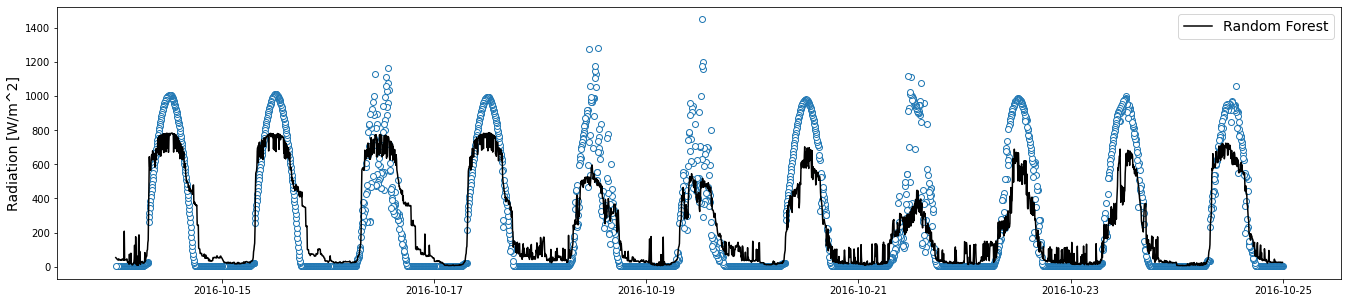

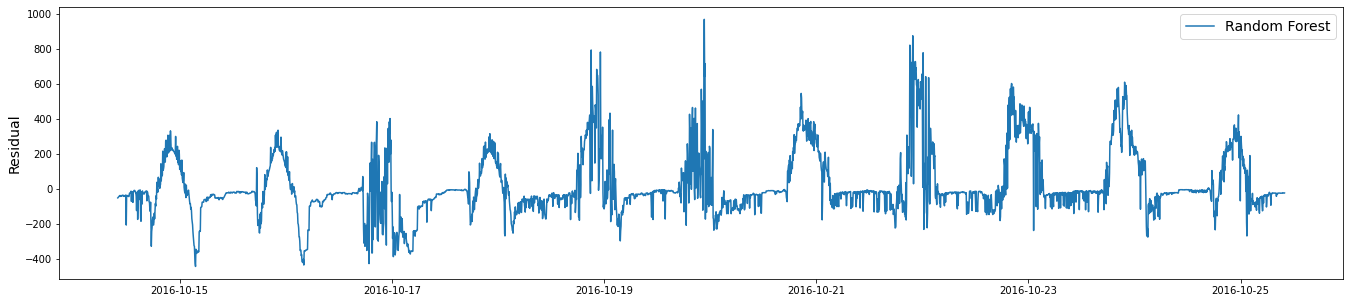

In [81]:
df_visual, y_pred_visual = truncate(RelTimeCase.df, rfRelTime, startDateVisual, endDateVisual)
visualInspect(df_visual, y_pred_visual, 'Random Forest')
plot_residuals(df_visual.Radiation, y_pred_visual, 'Random Forest')

### Gradient Boosting

Gradient boosting, an ensemble method which builds many decision trees sequentially.

In [82]:
#Define the grid of hyperparameters
# 'n_estimators': [500, 600, 700],
params_gb = {
    'n_estimators': tree_based_estimators,
    'max_depth': [5, 6, 7],
    'min_samples_leaf': [0.075, 0.05, 0.025],
    'max_features': ['log2', 'sqrt']   
}
gbRelTime = TreeBasedWrapper(GradientBoostingRegressor(random_state = 100), 
                                params = params_gb,
                                df = RelTimeCase.df,
                                test_size = test_size, 
                                series_split = series_split,
                                feature_case = RelTimeCase.featureCase)


In [83]:
#Fit best model
gbRelTime.fit()

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   34.2s finished


In [84]:
#Find best parameters
gbRelTime.best_parameters()

Best hyperparameters: 
 {'n_estimators': 500, 'min_samples_leaf': 0.025, 'max_features': 'log2', 'max_depth': 5}


In [85]:
#Find best model
gbRelTime.best_model()

In [86]:
#Check if there is overfitting through the use of Cross validation
gbRelTime.cross_validation()

In [87]:
#Compute Random Forest predictions in the traning and test sets
gbRelTime.predict()

In [88]:
gbRelTimeScores = gbRelTime.get_scores()
print(gbRelTimeScores)
SCORES_.append(gbRelTimeScores)

{'model': 'GradientBoostingRegressor', 'feature_case': 'rel_time', 'cv_mse': '9792.25', 'train_mse': '8253.57', 'test_mse': '8690.75', 'train_r2': '0.92', 'test_r2': '0.91'}


### Visual and Residual plots

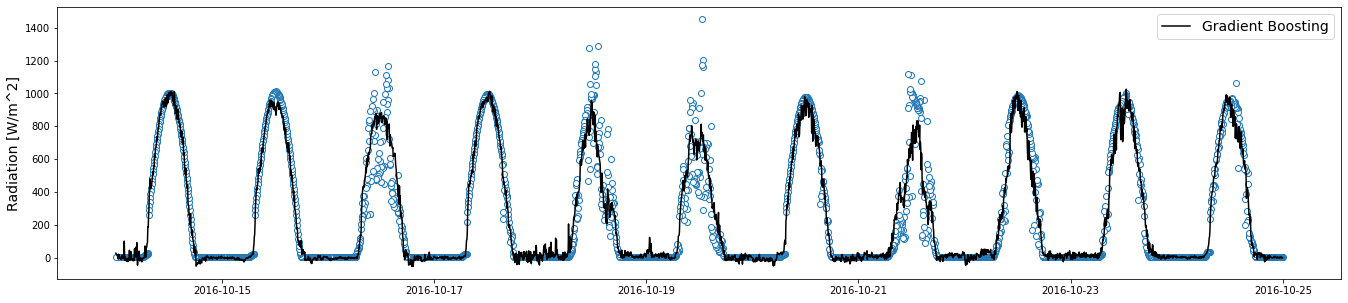

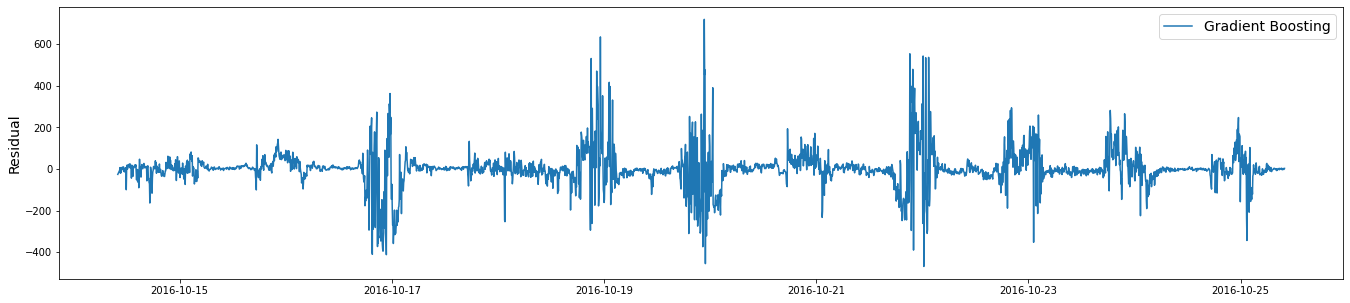

In [89]:
df_visual, y_pred_visual = truncate(RelTimeCase.df, gbRelTime, startDateVisual, endDateVisual)
visualInspect(df_visual, y_pred_visual, 'Gradient Boosting')
plot_residuals(df_visual.Radiation, y_pred_visual, 'Gradient Boosting')

## Feature Importance

throw NotImplementedException

In [90]:
#Plotting feature importances for Random Forest and Gradient boosting

def feature_importance_plots(model_1, model_2):
    #Creating a pd.Series of feature importances
    importances_rf = pd.Series(model_1.best_model_.feature_importances_, index = model_1.X.columns)
    importances_gb = pd.Series(model_2.best_model_.feature_importances_, index = model_2.X.columns)

    #Sorting importances
    sorted_importances_rf = importances_rf.sort_values()
    sorted_importances_gb = importances_gb.sort_values()

    #Plotting sorted importances
    fig, ax = plt.subplots(ncols = 2, figsize = (27,7))
    sorted_importances_rf.plot(kind = 'barh', color = 'lightblue', ax = ax[0])
    sorted_importances_gb.plot(kind = 'barh', color = 'lightblue', ax = ax[1])
    ax[0].set_title('Random Forest Regressor')
    ax[1].set_title('Gradient Boosting Regressor')
    fig.suptitle('Feature importances in the two ML models', fontsize = 24)
    plt.show()

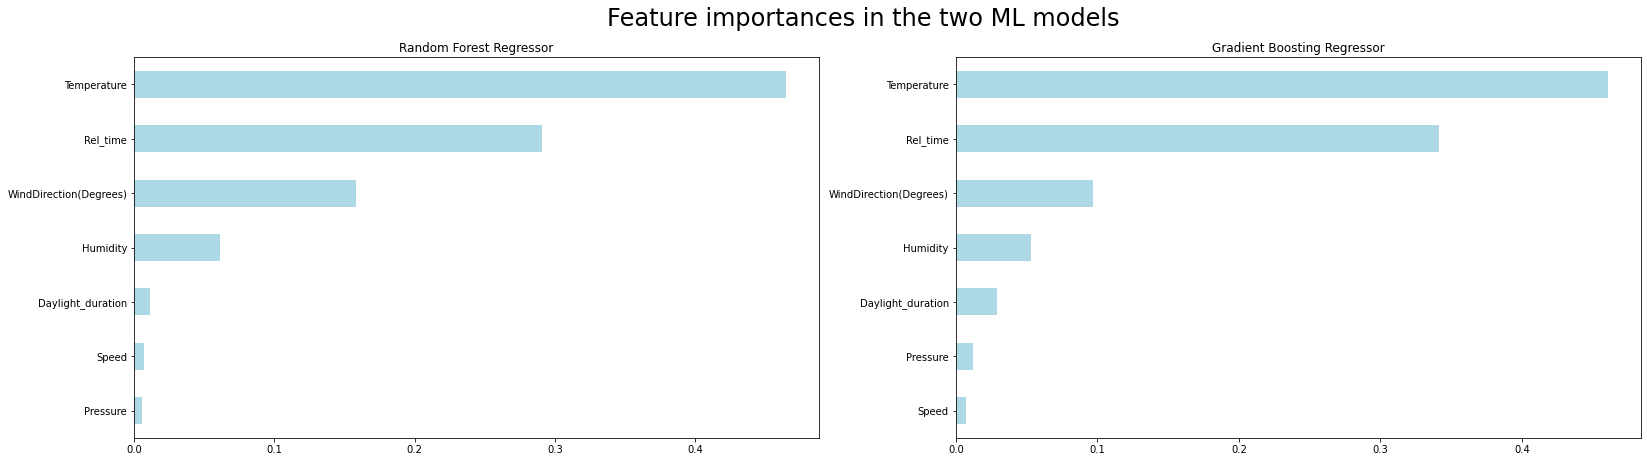

In [91]:
feature_importance_plots(rfRelTime, gbRelTime)

## Feature Engineering II

In this case we will create a new feature 'Sun_is_up' which will indicate whether the observation was made within Sunset and Sunrise duration(Daylight). 

- Sun_is_up = 1, if within daylight duration
- Sun_is_up = 0, if outside of daylight duration

In this way we 'transform' the essense of the dataset by introducing a hard cut off. We treat as there is no solar radiation just outside of sunrise, sunset. Intuitevely, we know that radiation drops of dramatically outside of this region, though it is not zero.


We will reload the dataset and perform same preprocessing steps.

In [92]:
SunUpCase = FeatureCreation('sun_is_up')
SunUpCase.loadDataset("solar_radiation_dataset.csv")
#Again fixing dataset and setting correct time zone
SunUpCase.fixTimeZone()
SunUpCase.timeConversion()


SunUpCase.createFeature()
SunUpCase.dropColumns(['Data', 'Time', 'TimeSunRise', 'TimeSunSet', 'UNIXTime', 
                               'sunrise_time', 'sunset_time'])

SunUpCase.df.loc[SunUpCase.df['sun_is_up'] == 1].head()

Creating feature sun_is_up
Proportion of record with the sun up : 47.75%


,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,sun_is_up
Date,,,,,,,
2016-09-29 18:10:52-10:00,6.63,53,30.44,59,118.82,5.62,1
2016-09-29 18:05:22-10:00,10.96,54,30.44,59,154.16,4.50,1
2016-09-29 18:00:22-10:00,19.42,55,30.44,57,58.42,6.75,1
2016-09-29 17:55:22-10:00,27.14,55,30.44,53,47.86,4.50,1
2016-09-29 17:50:19-10:00,33.75,56,30.44,52,74.56,2.25,1


We see that almost half of the observations performed during daylight.
Correlation matrix of new dataset

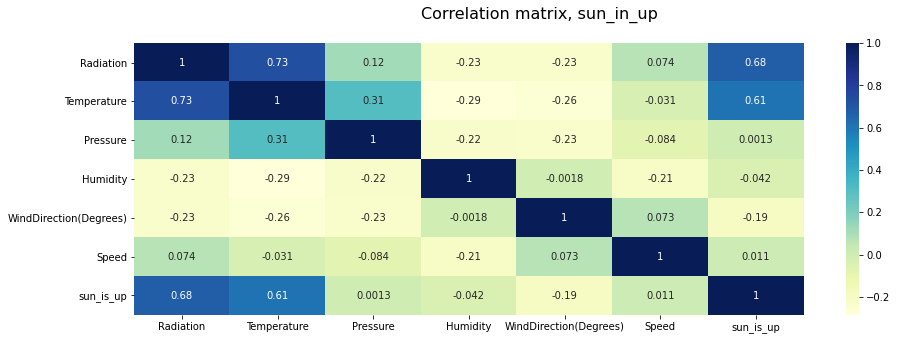

In [93]:
corrMatrix(SunUpCase.df, 'sun_in_up')

### Linear Model II

We fit again a simple linear model to establish a basic performace point

In [94]:
lmSunUp = LinearRegressionWrapper(df = SunUpCase.df, test_size = test_size, feature_case='sun_is_up')
#Fit model
lmSunUp.fit()
#Predictions
lmSunUp.predict()
#Print scores
lmSunUpScores = lmSunUp.get_scores()
print(lmSunUpScores)
SCORES_.append(lmSunUpScores)

{'model': 'LinearRegression', 'feature_case': 'sun_is_up', 'train_mse': '36117.95', 'test_mse': '35528.59', 'train_r2': '0.64', 'test_r2': '0.64'}


### Random Forest II

In [95]:
#Define the grid of hyperparameters
# 'n_estimators': [500, 600, 700],
params_rf = {
    'n_estimators': tree_based_estimators,
    'max_depth': [5, 6, 7],
    'min_samples_leaf': [0.075, 0.05, 0.025],
    'max_features': ['log2', 'sqrt']   
}
rfSunUp = TreeBasedWrapper(RandomForestRegressor(random_state = 100), 
                                params = params_rf,
                                df = SunUpCase.df,
                                test_size = test_size, 
                                series_split = series_split,
                                feature_case = SunUpCase.featureCase)
#Fit best model
rfSunUp.fit()
#Find best parameters
rfSunUp.best_parameters()

rfSunUp.best_model()

rfSunUp.cross_validation()

rfSunUp.predict()

rfSunUpScores = rfSunUp.get_scores()
print(rfSunUpScores)
SCORES_.append(rfSunUpScores)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   30.6s finished


Best hyperparameters: 
 {'n_estimators': 100, 'min_samples_leaf': 0.025, 'max_features': 'log2', 'max_depth': 5}
{'model': 'RandomForestRegressor', 'feature_case': 'sun_is_up', 'cv_mse': '29666.72', 'train_mse': '29654.86', 'test_mse': '29780.06', 'train_r2': '0.70', 'test_r2': '0.70'}


### Visual and Residual plots

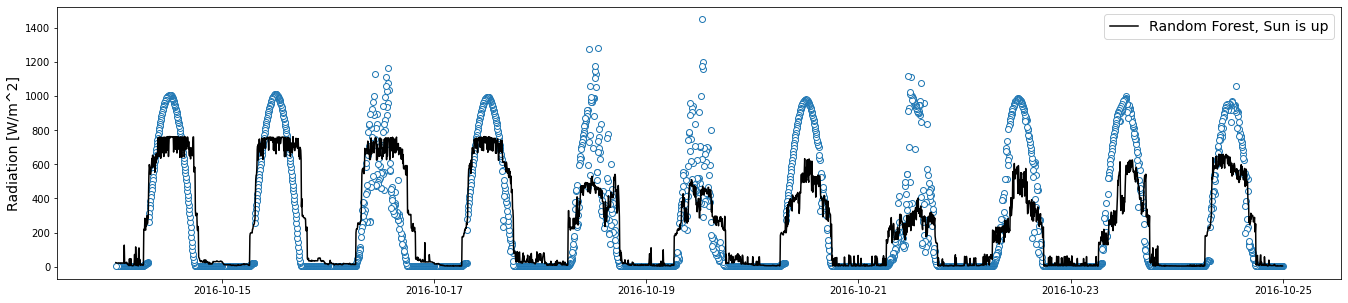

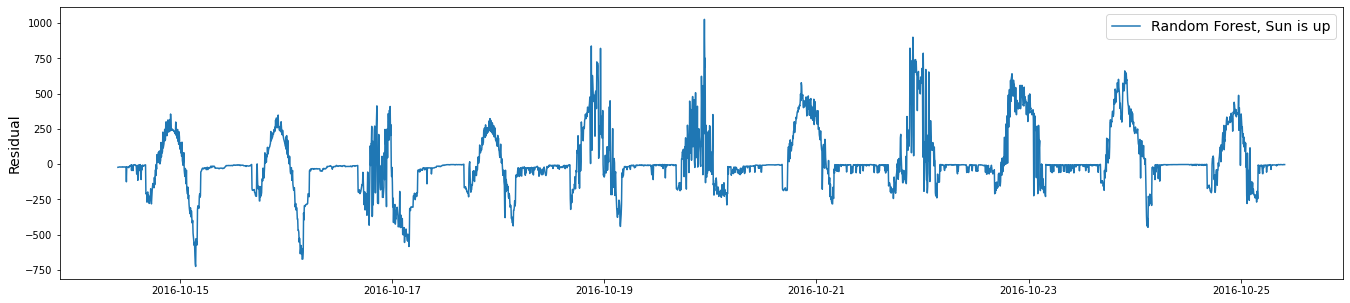

In [96]:
df_visual, y_pred_visual = truncate(SunUpCase.df, rfSunUp, startDateVisual, endDateVisual)
visualInspect(df_visual, y_pred_visual, 'Random Forest, Sun is up')
plot_residuals(df_visual.Radiation, y_pred_visual, 'Random Forest, Sun is up')

### Gradient Boosting II

In [97]:
#Define the grid of hyperparameters
# 'n_estimators': [500, 600, 700],
params_gb = {
    'n_estimators': tree_based_estimators,
    'max_depth': [5, 6, 7],
    'min_samples_leaf': [0.075, 0.05, 0.025],
    'max_features': ['log2', 'sqrt']   
}
gbSunUp = TreeBasedWrapper(GradientBoostingRegressor(random_state = 100), 
                                params = params_gb,
                                df = SunUpCase.df,
                                test_size = test_size, 
                                series_split = series_split,
                                feature_case = SunUpCase.featureCase)
#Fit best model
gbSunUp.fit()
#Find best parameters
gbSunUp.best_parameters()

gbSunUp.best_model()

gbSunUp.cross_validation()

gbSunUp.predict()

gbSunUpScores = gbSunUp.get_scores()
print(gbSunUpScores)
SCORES_.append(gbSunUpScores)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   47.8s finished


Best hyperparameters: 
 {'n_estimators': 500, 'min_samples_leaf': 0.05, 'max_features': 'sqrt', 'max_depth': 6}
{'model': 'GradientBoostingRegressor', 'feature_case': 'sun_is_up', 'cv_mse': '24442.41', 'train_mse': '22557.26', 'test_mse': '23989.76', 'train_r2': '0.77', 'test_r2': '0.76'}


### Visual and Residulas plots

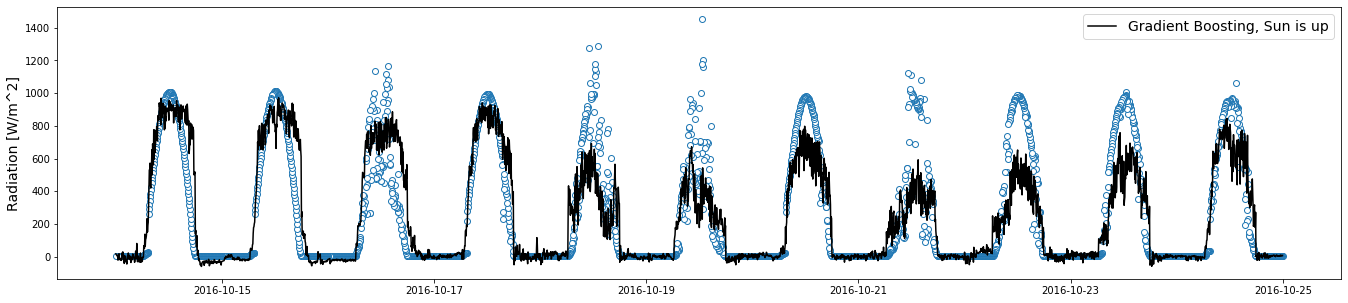

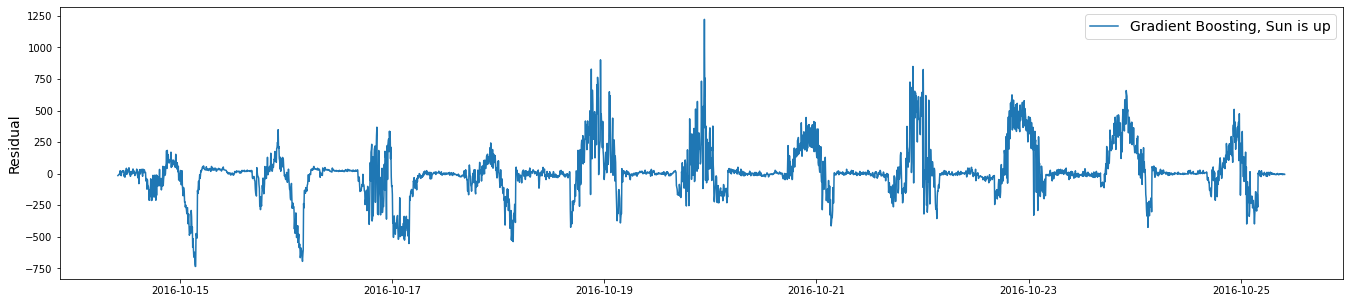

In [98]:
df_visual, y_pred_visual = truncate(SunUpCase.df, gbSunUp, startDateVisual, endDateVisual)
visualInspect(df_visual, y_pred_visual, 'Gradient Boosting, Sun is up')
plot_residuals(df_visual.Radiation, y_pred_visual, 'Gradient Boosting, Sun is up')

### Featurn Importance

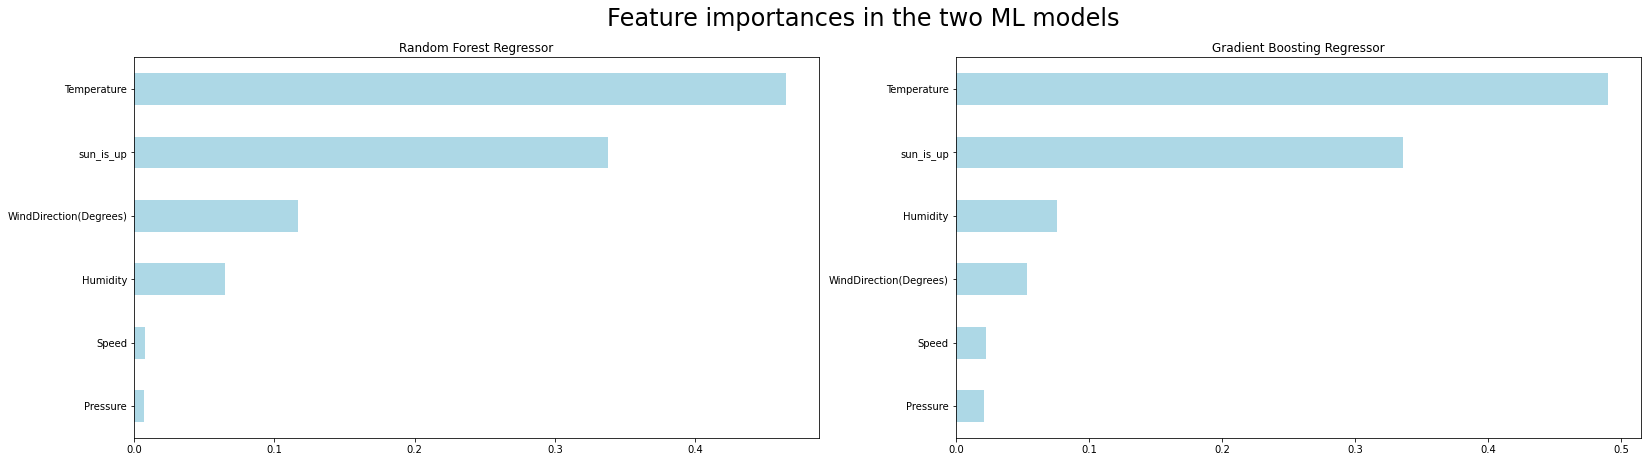

In [99]:
feature_importance_plots(rfSunUp, gbSunUp)


## Summary

In [100]:
import json
for case in SCORES_:
    print (json.dumps(case, sort_keys=False, indent=4))

{
    "model": "LinearRegression",
    "feature_case": "rel_time",
    "train_mse": "38061.81",
    "test_mse": "37879.92",
    "train_r2": "0.62",
    "test_r2": "0.62"
}
{
    "model": "RandomForestRegressor",
    "feature_case": "rel_time",
    "cv_mse": "23485.14",
    "train_mse": "23143.94",
    "test_mse": "23067.83",
    "train_r2": "0.77",
    "test_r2": "0.77"
}
{
    "model": "GradientBoostingRegressor",
    "feature_case": "rel_time",
    "cv_mse": "9792.25",
    "train_mse": "8253.57",
    "test_mse": "8690.75",
    "train_r2": "0.92",
    "test_r2": "0.91"
}
{
    "model": "LinearRegression",
    "feature_case": "sun_is_up",
    "train_mse": "36117.95",
    "test_mse": "35528.59",
    "train_r2": "0.64",
    "test_r2": "0.64"
}
{
    "model": "RandomForestRegressor",
    "feature_case": "sun_is_up",
    "cv_mse": "29666.72",
    "train_mse": "29654.86",
    "test_mse": "29780.06",
    "train_r2": "0.70",
    "test_r2": "0.70"
}
{
    "model": "GradientBoostingRegressor",
